In [78]:
#Packages
import collections
import math
import cmath
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image, ImageDraw, ImageFont, ImageColor
import numpy as np 
from scipy.stats import norm
from scipy import ndimage
from scipy.stats import truncnorm, uniform,randint
import json
import pandas as pd
import os
from tqdm import notebook
import random
from my_classes import STMImage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import generic_filter,convolve
from scipy.fft import ifft

In [177]:
#Defining functions of hexogonal grid
Point = collections.namedtuple("Point", ["x", "y"])
_Hex = collections.namedtuple("Hex", ["q", "r", "s"])

def Hex(q, r, s): #creates the hexagon datatype 
    assert not (round(q + r + s) != 0), "q + r + s must be 0"
    return _Hex(q, r, s)

# Datatypes for pointy top or flattop lattices
Orientation = collections.namedtuple("Orientation", ["f0", "f1", "f2", "f3", "b0", "b1", "b2", "b3", "start_angle"])
Layout = collections.namedtuple("Layout", ["orientation", "size", "origin"])
layout_pointy = Orientation(math.sqrt(3.0), math.sqrt(3.0) / 2.0, 0.0, 3.0 / 2.0, math.sqrt(3.0) / 3.0, -1.0 / 3.0, 0.0, 2.0 / 3.0, 0.5)
layout_flat = Orientation(3.0 / 2.0, 0.0, math.sqrt(3.0) / 2.0, math.sqrt(3.0), 2.0 / 3.0, 0.0, -1.0 / 3.0, math.sqrt(3.0) / 3.0, 0.0)

#Unit vectors defining three axes of strain. From the center of a hexagon unit cell, q points to the downward right face, r points to the downward face, and b points to the downward right face. q and r also are the same axes the hexagonal lattice is defined with.
r_hat=np.array([0,1])
q_hat=np.array([math.sqrt(3)/2,1/2])
b_hat=r_hat-q_hat
b_hat=b_hat/np.linalg.norm(b_hat)
#Functions for locating points in xy coordinates
def hex_to_pixel(layout, h, strain): #returns the x,y coordinate of the center of the hexagon, strain is an array [q,r,s] of percent strain in each direction
    M = layout.orientation
    x = ((M.f0*h.q+M.f1*h.r))*layout.size[0]
    y = ((M.f2*h.q+M.f3*h.r))*layout.size[1]
    h_b=h.r-h.q
    strain_vec_q=np.array([strain[0]*layout.size[0]*(h.q+1/2*h.r)*q_hat[0],strain[0]*layout.size[1]*(h.q+1/2*h.r)*q_hat[1]])
    strain_vec_r=np.array([strain[1]*layout.size[0]*(h.r+1/2*h.q)*r_hat[0],strain[1]*layout.size[1]*(h.r+1/2*h.q)*r_hat[1]])
    strain_vec_b=np.array([strain[2]*layout.size[0]*(h_b-1/2*h.r+1/2*h.q)*b_hat[0],strain[2]*layout.size[1]*(h_b-1/2*h.r+1/2*h.q)*b_hat[1]])
    strain_vec=strain_vec_q+strain_vec_r+strain_vec_b
    return Point(x +strain_vec[0]+ layout.origin[0] , y +strain_vec[1]+ layout.origin[1])

def hex_corner_offset(layout, corner): #Returns how far off each corner is from the center point
    M = layout.orientation
    size = layout.size
    angle = 2.0 * math.pi * (M.start_angle - corner) / 6.0
    return Point(size[0] * math.cos(angle), size[1] * math.sin(angle))


r_strain_order=[0,-1,-1,0,1,1]
q_strain_order=[1,0,-1,-1,0,1]
b_strain_order=[-1,-1,0,1,1,0]
def get_corner_strain_vec(i,strain):
    strain_order_vec=np.array([q_strain_order[i],r_strain_order[i],b_strain_order[i]])
    strain_vec=q_hat/2*strain[0]*strain_order_vec[0]+r_hat/2*strain[1]*strain_order_vec[1]+b_hat/2*strain[2]*strain_order_vec[2]
    return strain_vec

def polygon_corners(layout, h,strain): #Creates an array of corners by applying the corner offset method to the center six times
    corners = []
    center = hex_to_pixel(layout, h,strain)
    for i in range(0, 6):
        offset = hex_corner_offset(layout, i)
        strain_vec=get_corner_strain_vec(i,strain)
        corners.append(Point(center.x + offset.x + strain_vec[0]*layout.size[0], center.y + offset.y + strain_vec[1]*layout.size[1]))
    return corners

def get_neighbor_vec(layout,strain,i,R): #Creates an array of corners by applying the corner offset method to the center six times
    offset = hex_corner_offset(layout, i)
    strain_vec=get_corner_strain_vec(i,strain)
    vec_init=np.array([offset.x + strain_vec[0]*layout.size[0], offset.y + strain_vec[1]*layout.size[1]])
    vec=rotate_vec(vec_init,R)
    return np.array([vec[0],vec[1]])

def to_array(corners): # turns corners into an array of arrays for coordinates
    array_corners=[]
    for p in corners:
        array_corners.append([p.x,p.y])
    return array_corners

# Creates rectangular map of hexagons for flat top, origin is in top left
def rect_map(map_height,map_width):
    map=[]
    for q in range(-map_height,map_height):
        q_offset=math.floor(q/2)
        for r in range(-map_width-q_offset,map_width-q_offset):
            #map.append(Hex(q,r-map_height//2,-(q)-(r-map_height//2)))
            map.append(Hex(q,r,-q-r))
    return map

#Gaussian function to be used globably
Gaussian= lambda x,scl,amp: amp*math.e**(-0.5*(x/scl)**2)
Gaussian2D= lambda x,y,sclx,scly,amp:amp*math.e**(-0.5*(x/sclx)**2-0.5*(y/scly)**2)
#Gaussian2Dtheta= lambda x,y,sclx,scly,theta: 1/(2*np.pi*sclx*scly)*np.exp(-1/(2*sclx**2)*(x*math.cos(theta)+y*math.sin(theta))**2-1/(2*scly**2)*(x*math.sin(theta)-y*math.cos(theta))**2)
Gaussian2Dtheta= lambda x,y,sclx,scly,theta: np.exp(-1/(2*sclx**2)*(x*math.cos(theta)+y*math.sin(theta))**2-1/(2*scly**2)*(x*math.sin(theta)-y*math.cos(theta))**2)
Lorentzian=lambda x,scl,amp: amp*(1/math.pi)*(0.5*scl)/(math.pow(x,2)+math.pow(0.5*scl,2))

def get_gaussian_kernel(sclx,scly,theta):
    kernel=np.zeros((9,9))
    for x in range(0,9):
        for y in range(0,9):
            kernel[y][x]=Gaussian2Dtheta(x-4,y-4,sclx,scly,theta)
    return kernel
    
#Labeling methods
def distance(a,mid): #Returns the distance between two pixels
    dist_vec=np.array((mid[0]-a[0],mid[1]-a[1]))
    distance=np.linalg.norm(dist_vec)
    return distance

#Rotation method
def rotate_vec(v,R,_origin=[0,0]): #Rotates given point by predetermined angle around origin, which is set to (0,0) by default
    org=np.array(_origin)
    vec=v-org
    return np.tensordot(R,vec,axes=1)

0.006737946999085467


<IPython.core.display.Javascript object>


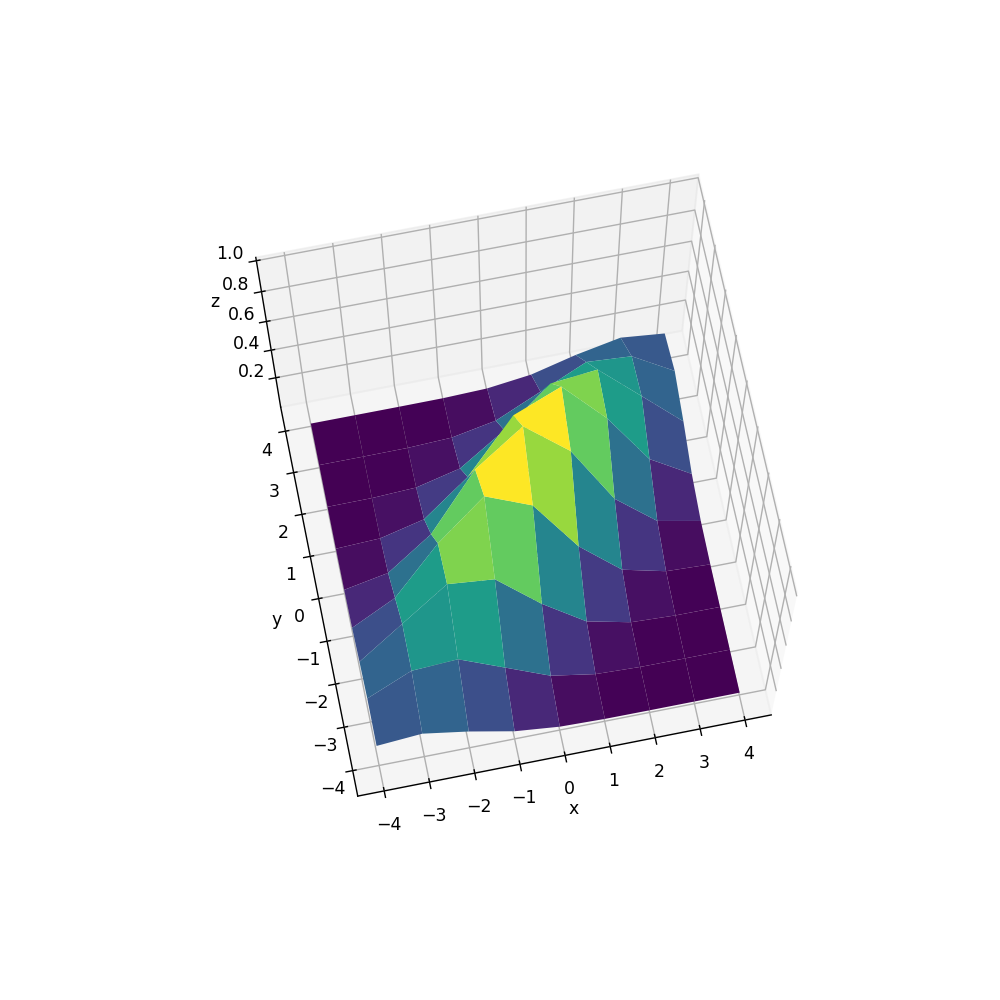

Text(0.5, 0, 'y')

In [181]:
%matplotlib notebook
# x = np.linspace(-10,10,80)
# y = np.linspace(-10,10,80)
# xv, yv = np.meshgrid(x,y)
# sclx,scly,theta=(3,1,np.pi/2)
# fig=plt.figure(figsize=(8,8))
# ax=fig.add_subplot(111,projection='3d')
# height3d=ax.plot_surface(xv,yv,Gaussian2Dtheta(xv,yv,sclx,scly,theta),linewidth=0,alpha=1,cmap='viridis')
# #height3d=ax.plot_surface(xv,yv,Gaussian2D(xv,yv,sclx,scly,1),linewidth=0,alpha=1,cmap='viridis')
# #plot_labels_3d()
# ax.set_zlabel('z')
# ax.set_xlabel('x')
# ax.set_ylabel('y')


kernel=get_gaussian_kernel(3,1,np.pi/4)
#print(kernel)
print(Gaussian2Dtheta(-3,-3,3,1,0))
x = np.linspace(-4,4,9)
y = np.linspace(-4,4,9)
xv, yv = np.meshgrid(x,y)
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection='3d')
height3d=ax.plot_surface(xv,yv,kernel,linewidth=0,alpha=1,cmap='viridis')
#height3d=ax.plot_surface(xv,yv,Gaussian2D(xv,yv,sclx,scly,1),linewidth=0,alpha=1,cmap='viridis')
#plot_labels_3d()
ax.set_zlabel('z')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [5]:
#Function that generates scan line noise. Method from Barnsley 1988 1.4.2, Fast Fourier Transform filtering
def fBm(N,B,seed):
    length = N*N*2
    phases = uniform.rvs(loc=0,scale=2*math.pi,random_state=seed,size=length//2)
    vm=[]
    for m in range(length//2):
        vm.append(1/math.pow(m+0.000001,B/2)*cmath.exp(1j*phases[m]))
    for m in range(length//2):
        vm.append(0)
    V=ifft(vm)
    #Reshape and take only forward scan layer
    V=np.array(V)
    V=V.real
    V=V.reshape(N,2,N)
    V=np.take(V,0,axis=1)
    #Normalize:
    V -= np.mean(V)
    V_max=np.max(V)
    V /= V_max
    return V
    
# lines=fBm(512,1,42)
# np.save("512_scan_lines.npy",lines)

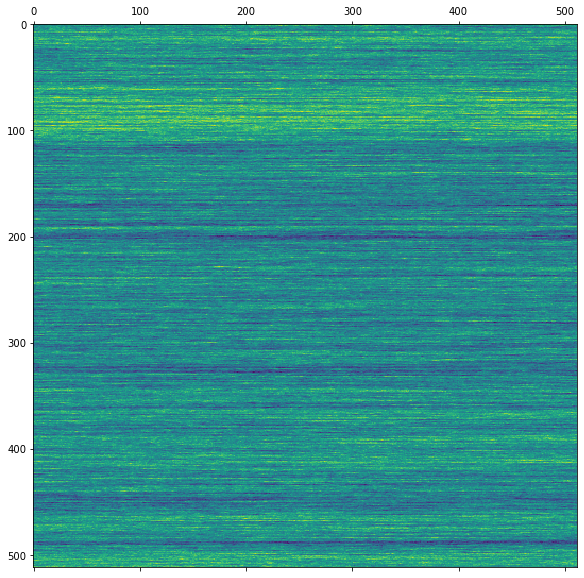

In [4]:
#Cell for plotting scan noise
lines=fBm(512,1,42)
#lines= gaussian_filter(lines,[0,2])


fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(1,1,1)
ax.matshow(lines,cmap='viridis')


In [219]:
#Class for training images
class Training_im:

    image_size=[32+8,32+8]
    background_color=ImageColor.getrgb("hsl(46,0%,50%)")
    def __init__(self,bond_lengths,origin,atom_size,strain,angle,corr,smear_theta,height_var=0.01,noise_percent=0.5,b=1,N=512):
        self.bl=bond_lengths #bond lengths in [x,y] scaleing
        self.o=origin #orignin from which to draw lattice. In effect will shift the entire image up and down
        self.atom_size=atom_size #Standard deviation of the gaussian each atom is represented by
        self.strain=np.array(strain) #Strain in [q,r,b] direction, number is percent strain in that direction, ie q=.5 adds 50% of the bond length to each point in the q direction
        theta=np.radians(angle)
        c,s= np.cos(theta),np.sin(theta)
        self.R=np.matrix([[c,s],[-s,c]]) #Rotation matrix for given angle. Rotates counterclockwise
        self.corr=corr
        self.height_var=height_var
        self.N=N
        self.b=b
        self.smear_theta=smear_theta
        self.noise_perc=noise_percent
        self.im=Image.new("RGB",self.image_size,color=self.background_color)
        self.pixel_array=np.array(self.im)
        self.blob_values_array=np.zeros((self.image_size[1],self.image_size[0]))
        self.mid=Point(self.image_size[0]//2,self.image_size[1]//2)
        self.layout=Layout(layout_flat,self.bl,self.o)
        self.atom_locs=[]
        self.make_heights()
        self.neighbor_vects=[]
        self.central_atom=[]
        self.label_im()

    #Plotting methods
    def gauss_circ(self,p,radius): #Draws a gaussian blob at a given location
        #radius is a given param that represents the standard deviation of the gaussian
        #plot_rad is some multiple of the radius given, it is the radius of the circle to be plotted
        _scale=radius
        plot_rad=4*radius
        z_shift=norm.rvs(loc=1,scale=self.height_var)
        color_amp=self.corr*z_shift
        color_scaling=lambda x: Gaussian(x,_scale,color_amp)
        #color_scaling=lambda x: Lorentzian(x,_scale,color_amp)
        
        for x in range(math.floor(max(p[0]-plot_rad,0)),math.floor(min(p[0]+plot_rad,self.image_size[0]))):
            for y in range(math.floor(max(p[1]-plot_rad,0)),math.floor(min(p[1]+plot_rad,self.image_size[1]))):
                dist_vec=np.array([x-p[0],y-p[1]])
                distance=np.linalg.norm(dist_vec)
                self.blob_values_array[y][x]+=color_scaling(distance)
                
    def gauss_circ_2D(self,p,radius): #Draws a gaussian blob at a given location
        #radius is a given param that represents the standard deviation of the gaussian
        #plot_rad is some multiple of the radius given, it is the radius of the circle to be plotted
        _scale=radius
        plot_rad=4*radius
        z_shift=norm.rvs(loc=1,scale=self.height_var)
        color_amp=self.corr*z_shift
        smearing=1
        color_scaling_2D=lambda x,y: Gaussian2D(x,y,smearing*_scale,_scale,color_amp)
        
        for x in range(math.floor(max(p[0]-plot_rad,0)),math.floor(min(p[0]+plot_rad,self.image_size[0]))):
            for y in range(math.floor(max(p[1]-plot_rad,0)),math.floor(min(p[1]+plot_rad,self.image_size[1]))):
                dist_vec=np.array([x-p[0],y-p[1]])
                self.blob_values_array[y][x] += color_scaling_2D(dist_vec[0],dist_vec[1])
    
    def plot_hex_dots(self): #Calls gauss_circ on every point in atom_locs
        for p in self.atom_locs:
            self.gauss_circ_2D(p,self.atom_size)
            
    def add_lines(self):
        x0=random.randint(0,self.N-self.image_size[0])
        y0=random.randint(0,self.N-self.image_size[1])
        lines=LINES
        #lines= gaussian_filter(lines,[0,2])
        lines *=self.corr*self.noise_perc
        lines=np.take(lines,range(y0,y0+self.image_size[1]),axis=0)
        lines=np.take(lines,range(x0,x0+self.image_size[0]),axis=1)
        self.lines=lines
        self.blob_values_array+=lines
        
    def add_speckle_noise(self):
        for y in range(self.blob_values_array.shape[1]):
            for x in range(self.blob_values_array.shape[0]):
                self.blob_values_array[x,y] *=truncnorm.rvs(a=(.9-1)/0.01,b=(1.1-1)/0.01,loc=1,scale=0.01)
        
    #Rotation methods
    def rotate_point(self,p): #Rotates given point by predetermined angle around origin, which is set to (0,0) by default
        origin=np.array(self.o)
        v=np.array(p)
        vec=v-origin
        rot_point=np.tensordot(self.R,vec,axes=1)
        return [rot_point[0]+origin[0],rot_point[1]+origin[1]]
        
    def rotate_atoms(self,atom_locs): #Rotates all the atom locations in the given array
        atom_locs_rot=[]
        for p in atom_locs:
            atom_locs_rot.append(self.rotate_point(p))
        return atom_locs_rot

    #Neighbor methods
    def get_atom_locs(self,_map): # Returns an array of all the atomic locations in the map
        atom_locs=[]
        for h in _map:
            corners=to_array(polygon_corners(self.layout,h,self.strain))
            for corner in corners[0:2]:
                atom_locs.append(corner)
        atom_locs_rot=self.rotate_atoms(atom_locs)
        return atom_locs_rot
    
    def get_central_atom(self,atom_locs): #Returns the atom closest to the center pixel of the image
        center_atom=[]
        min_dist=self.image_size[0]
        for a in atom_locs:
            if distance(a,self.mid)<=min_dist:
                min_dist=distance(a,self.mid)
                center_atom=a
        return center_atom
        
    
    def initialize_neighbor_vec(self): #Initializes the neighbor vectors based on size/bond lentgh
        self.neighbor_vect_arr=[]
        for i in range(6):
            self.neighbor_vect_arr.append(get_neighbor_vec(self.layout,self.strain,i,self.R))

        
    def get_isRight(self,central): #Returns whether the central atom is on the right or left of the two triangular sublattices
        isRight=False
        left_neighbor_x=central[0]+self.neighbor_vect_arr[3][0]
        left_neighbor_y=central[1]+self.neighbor_vect_arr[3][1]
        for a in self.atom_locs:
            if left_neighbor_x-1<=a[0] and left_neighbor_x+1>=a[0]:
                if left_neighbor_y-1<=a[1] and left_neighbor_y+1>=a[1]:
                    isRight=True
        return isRight
    

    def get_nearest_neighbors(self,atom_locs,central): #Returns the nearest neighbors to the central atom. 
        #Doesn't search atom locations, just spits out where the neighbors should be given central location
        neighbors=[]
        self.isRight=self.get_isRight(central)
        if self.isRight:
            neighbors.append(np.add(self.neighbor_vect_arr[3],central))
            neighbors.append(np.add(self.neighbor_vect_arr[5],central))
            neighbors.append(np.add(self.neighbor_vect_arr[1],central))
        else:
            neighbors.append(np.add(self.neighbor_vect_arr[0],central))
            neighbors.append(np.add(self.neighbor_vect_arr[2],central))
            neighbors.append(np.add(self.neighbor_vect_arr[4],central))
        return neighbors
    
    
    #Method for making 2D colored image
    #Takes all float values in blob_values_array and converts them to an hsl color with the corresponding lightness value. This color is then convereted to rgb and stored in pixel_array   
    def gauss_to_color(self):
        max_val=self.blob_values_array.max()
        self.rescaled_heights=self.blob_values_array*100/max_val
        for i in range(self.image_size[0]):
            for j in range(self.image_size[1]):
                rgbcolor=ImageColor.getrgb(f"hsl(46,{min(max(self.rescaled_heights[j][i],1e-2),100)}%,50%)")
                self.pixel_array[j][i][0]=rgbcolor[0]
                self.pixel_array[j][i][1]=rgbcolor[1]
                self.pixel_array[j][i][2]=rgbcolor[2]


    #Creates the hexagonal latice and adds a gaussian circle at each lattice point. Saves these values in blob_values_array and rescales it
    def make_heights(self):
        self.initialize_neighbor_vec()
        mapsize_x=math.floor(self.image_size[0]/(math.sqrt(3)*self.bl[0])*2)
        mapsize_y=math.floor(self.image_size[1]/(2*self.bl[1])*2)
        self.map=rect_map(mapsize_x,mapsize_y)
        self.atom_locs=self.get_atom_locs(self.map)
        self.plot_hex_dots()
        #self.add_lines()
        kernel=get_gaussian_kernel(6,1,self.smear_theta)
        self.blob_values_array=convolve(self.blob_values_array,kernel,mode='reflect')
        #self.blob_values_array=gaussian_filter(self.blob_values_array,[0,3])
        self.blob_values_array=self.blob_values_array[4:36,4:36]
        
    #Runs the methods required to draw the image and saves the final array as an Image instance
    def make_im(self):
        self.gauss_to_color()
        self.image=Image.fromarray(self.pixel_array)
   
    #Assigns labels to the image, calculates central atom and neighbors from atom_locs
    def label_im(self):
        central_atom=self.get_central_atom(self.atom_locs)-np.array([4,4])
        self.isRight=self.get_isRight(central_atom)
        if self.isRight:
            self.neighbor_vects.append(self.neighbor_vect_arr[3]/32.)
            self.neighbor_vects.append(self.neighbor_vect_arr[5]/32.)
            self.neighbor_vects.append(self.neighbor_vect_arr[1]/32.)
        else:
            self.neighbor_vects.append(self.neighbor_vect_arr[0]/float(self.image_size[0]))
            self.neighbor_vects.append(self.neighbor_vect_arr[2]/float(self.image_size[0]))
            self.neighbor_vects.append(self.neighbor_vect_arr[4]/float(self.image_size[0]))
        self.central_atom=[central_atom[0]/self.image_size[0],central_atom[1]/self.image_size[1]]
        
    


<IPython.core.display.Javascript object>


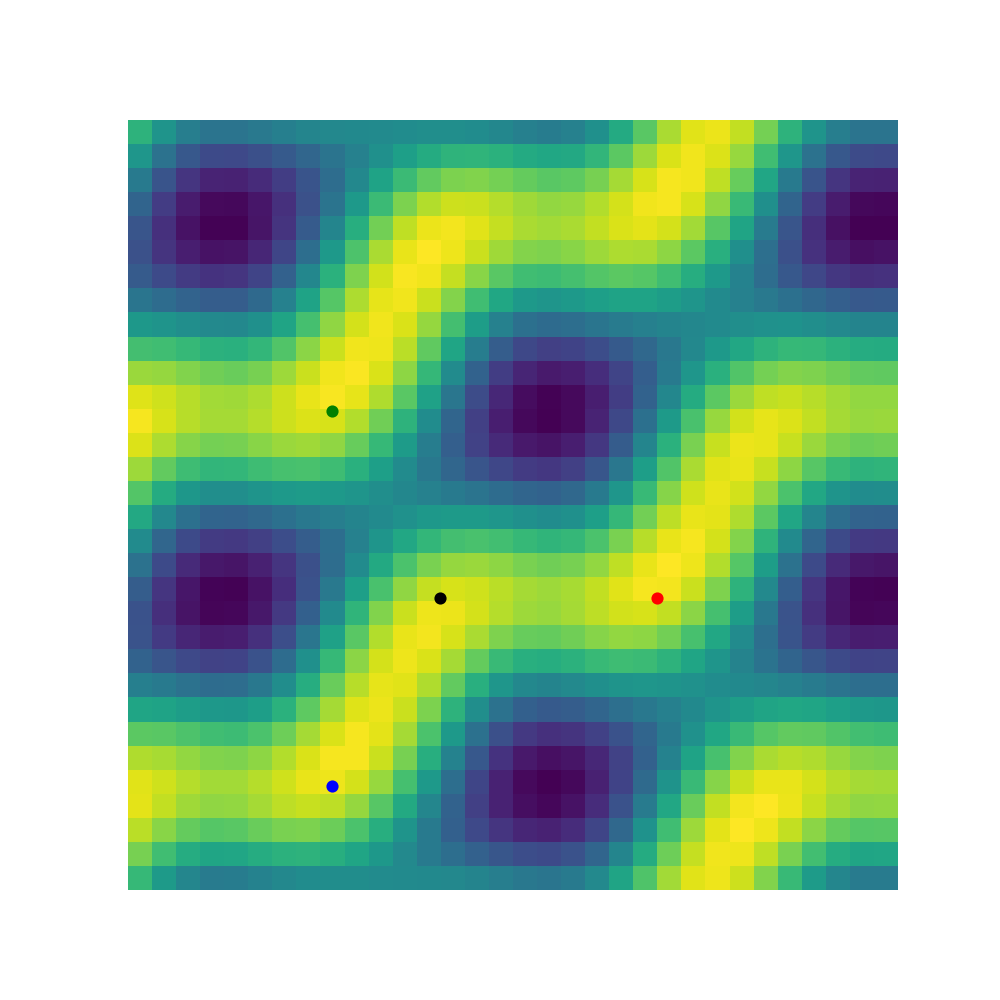

In [220]:
#Cell for plotting single image
im_scaling=Training_im.image_size[0]
def plot_labels_3d():
    height=Gaussian(0,atom_size,corr)
    s=30
    ax.scatter3D(center_atom[0]*im_scaling,center_atom[1]*im_scaling,height,'o',color='black',s=s)
    ax.scatter3D(neighbors[0][0]*im_scaling+center_atom[0]*im_scaling,neighbors[0][1]*im_scaling+center_atom[1]*im_scaling,height,'o',color='red',s=s)
    ax.scatter3D(neighbors[1][0]*im_scaling+center_atom[0]*im_scaling,neighbors[1][1]*im_scaling+center_atom[1]*im_scaling,height,'o',color='green',s=s)
    ax.scatter3D(neighbors[2][0]*im_scaling+center_atom[0]*im_scaling,neighbors[2][1]*im_scaling+center_atom[1]*im_scaling,height,'o',color='blue',s=s)

def plot_labels():
    plt.plot(center_atom[0]*im_scaling,center_atom[1]*im_scaling,'o',color='black')
    plt.plot(neighbors[0][0]*im_scaling+center_atom[0]*im_scaling,neighbors[0][1]*im_scaling+center_atom[1]*im_scaling,'o',color='red')
    plt.plot(neighbors[1][0]*im_scaling+center_atom[0]*im_scaling,neighbors[1][1]*im_scaling+center_atom[1]*im_scaling,'o',color='green')
    plt.plot(neighbors[2][0]*im_scaling+center_atom[0]*im_scaling,neighbors[2][1]*im_scaling+center_atom[1]*im_scaling,'o',color='blue')

bond_length = 9
origin = [-6,0]
atom_size = 3
#strain[q,r,b]
strain = [0,0,0]
#anlge in degrees
angle = 0
corr = 0.4
smear_theta=-.6
noise_percent=0.2
height_var=0.01
#LINES=fBm(512,1,42)
im = Training_im([bond_length,bond_length],origin,atom_size,strain,angle,corr,smear_theta,noise_percent=noise_percent,height_var=height_var)
center_atom=im.central_atom
neighbors=im.neighbor_vects

#Plots a 3D surface of the atom heights
%matplotlib notebook
# z = im.blob_values_array
# ny,nx = z.shape
# x = np.linspace(0,nx,nx)
# y = np.linspace(0,ny,ny)
# xv, yv = np.meshgrid(x,y)
# fig=plt.figure(figsize=(8,8))
# ax=fig.add_subplot(111,projection='3d')
# height3d=ax.plot_surface(xv,yv,z,linewidth=0,alpha=1,cmap='viridis')
# #plot_labels_3d()
# ax.set_zlabel('z')
# ax.set_xlabel('x')
# ax.set_ylabel('y')


# #Plots a 2D colored representaion of the atoms. Make sure corr=100
# #%matplotlib inline
fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(1,1,1)
ax.matshow(im.blob_values_array,cmap='viridis')
ax.axis('off')
plot_labels()


<IPython.core.display.Javascript object>


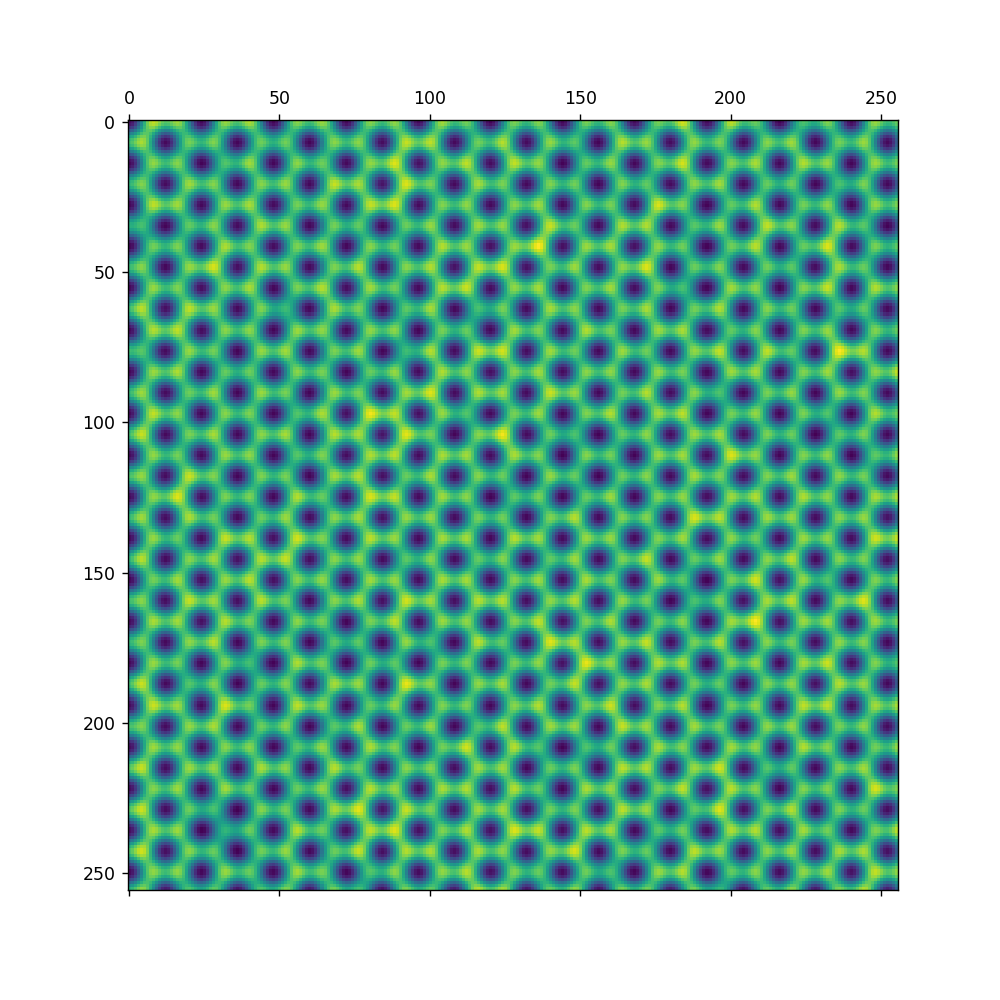

<IPython.core.display.Javascript object>


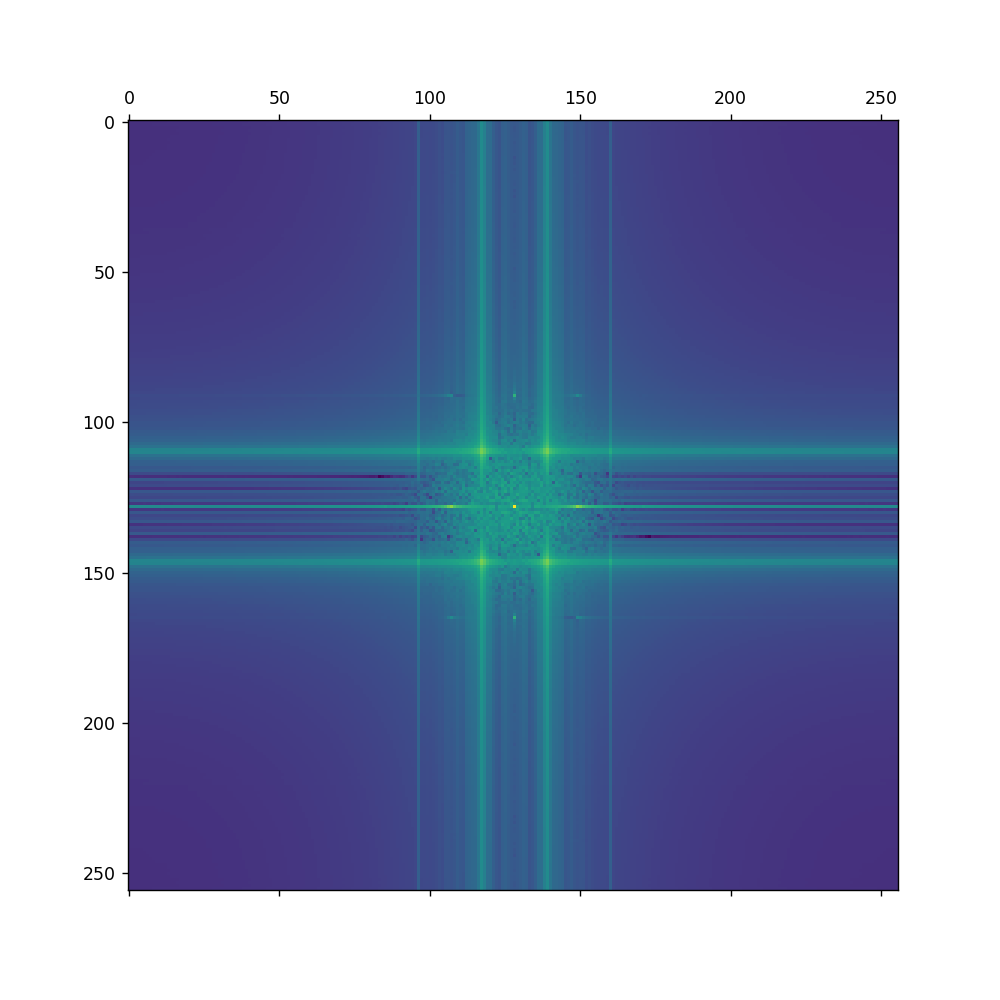

D:\anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


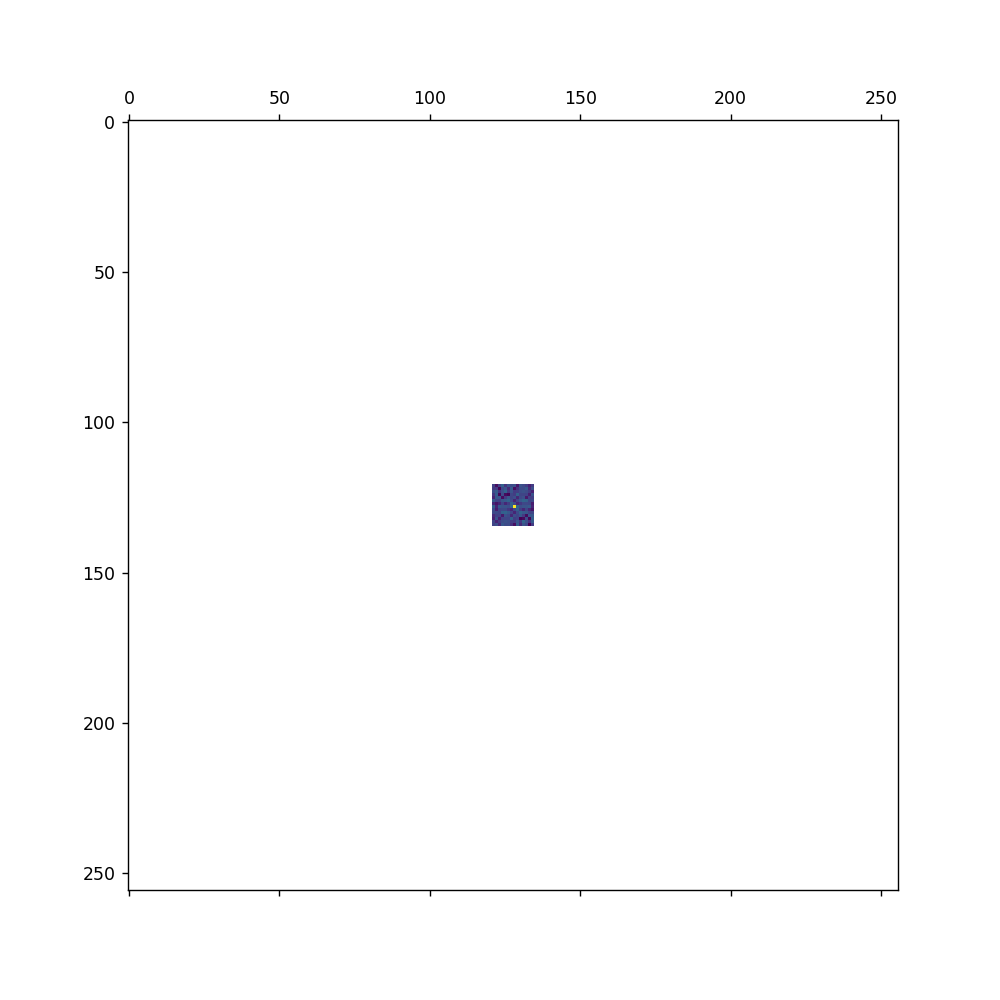

<IPython.core.display.Javascript object>


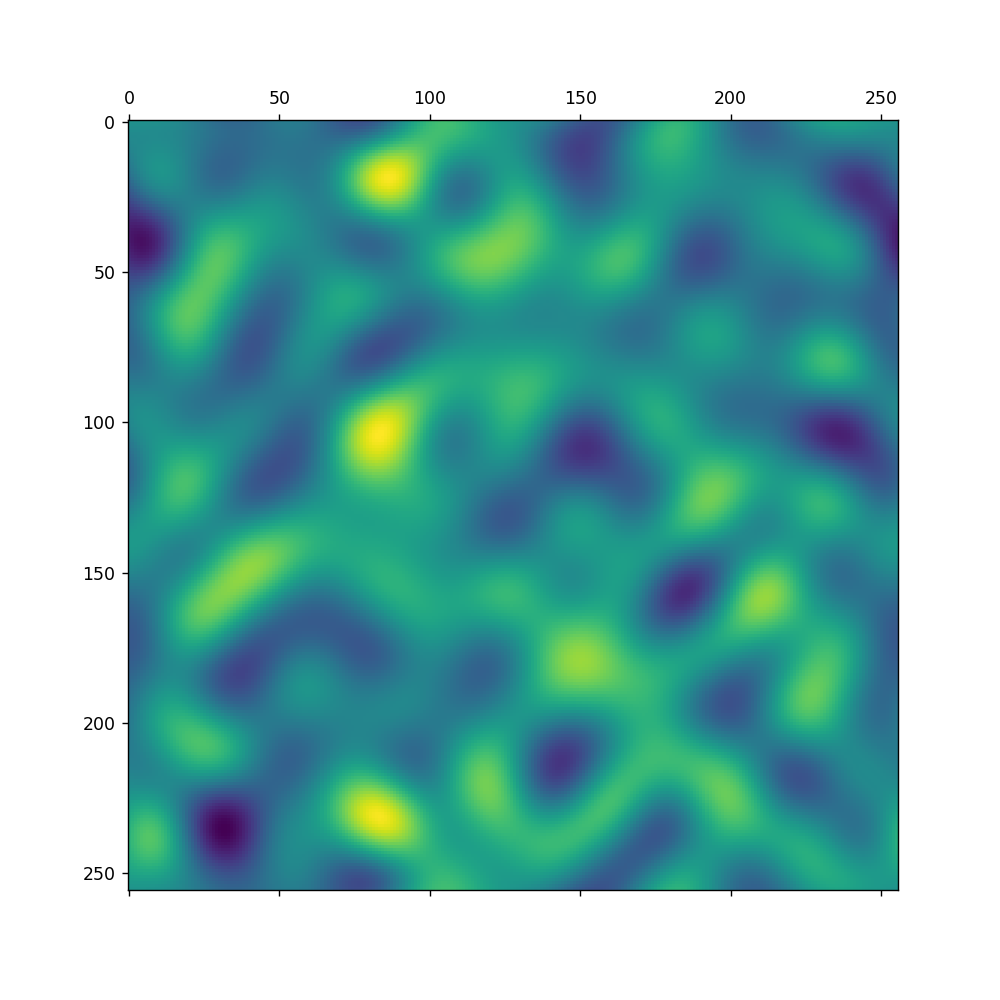

In [10]:
stm=im.blob_values_array
fsize=8
fig = plt.figure(figsize = (fsize, fsize))
ax = plt.subplot(1,1,1)
ax.matshow(stm,cmap='viridis')

f=np.fft.fft2(stm)
fshift=np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
fig = plt.figure(figsize = (fsize, fsize))
ax = plt.subplot(1,1,1)
ax.matshow(magnitude_spectrum,cmap='viridis')


rows, cols = stm.shape
crow,ccol = rows//2 , cols//2
mask=7
def mask_delete(mask):
    fshift[crow-mask:crow+mask, ccol-mask:ccol+mask] = 0
def mask_keep(arr,mask):
    arr[0:crow-mask] = 0
    arr[crow+mask:] = 0
    arr[crow-mask:crow+mask, 0:ccol-mask] = 0
    arr[crow-mask:crow+mask, ccol+mask:] = 0

mask_keep(fshift,mask)
#mask_delete(mask)

# fshift[110:114] = 0
# fshift[143:147] = 0
# moire_mask=1
# fshift[crow-moire_mask:crow+moire_mask, ccol-moire_mask:ccol+moire_mask] = 0

magnitude_spectrum = 20*np.log(np.abs(fshift))
fig = plt.figure(figsize = (fsize, fsize))
ax = plt.subplot(1,1,1)
ax.matshow(magnitude_spectrum,cmap='viridis')
# plt.xlim(50,200)
# plt.ylim(200,50)

f_ishift = np.fft.ifftshift(fshift)
stm_back = np.fft.ifft2(f_ishift)
stm_back = np.abs(stm_back)

fig = plt.figure(figsize = (fsize, fsize))
ax = plt.subplot(1,1,1)
ax.matshow(stm_back,cmap='viridis')


In [121]:
#Slicing up an STM image
from scipy import interpolate

def crop_and_resample_2darray(arr, x_crop, y_crop, resample, *args, **kwargs):
    """Crop a 2darray and resize the data"""
    
    len_x_crop = x_crop[1]-x_crop[0]
    len_y_crop = y_crop[1]-y_crop[0]

    arr_crop = arr[x_crop[0]:x_crop[1], y_crop[0]:y_crop[1]]
    f = interpolate.interp2d(np.arange(len_y_crop), 
                             np.arange(len_x_crop), 
                             arr_crop, 
                             *args, **kwargs)
    result = f(np.arange(len_x_crop, step=len_x_crop/resample[1]), 
             np.arange(len_y_crop, step=len_y_crop/resample[0]))
    return result

# def crop_and_resample_2darray(arr, x_crop, y_crop, resample, *args, **kwargs):
#     """Crop a 2darray and resize the data"""
    
#     len_x_crop = x_crop[1]-x_crop[0]
#     len_y_crop = y_crop[1]-y_crop[0]

#     arr_crop = arr[x_crop[0]:x_crop[1], y_crop[0]:y_crop[1]]
#     return arr_crop



size=20
step=20

stm_slice=np.zeros(((stm.shape[1]-size)//step,(stm.shape[0]-size)//step),dtype=object)

for i in range((stm.shape[0]-size)//step):
    for j in range((stm.shape[1]-size)//step):
        stm_slice[j][i]=crop_and_resample_2darray(stm,[j*step,j*step+size],[i*step,i*step+size],[32,32])

stm_slice_back=np.zeros(((stm_back.shape[1]-size)//step,(stm_back.shape[0]-size)//step),dtype=object)

for i in range((stm_back.shape[0]-size)//step):
    for j in range((stm_back.shape[1]-size)//step):
        stm_slice_back[j][i]=crop_and_resample_2darray(stm_back,[j*step,j*step+size],[i*step,i*step+size],[32,32])

print(stm_slice.shape)

(11, 11)


<IPython.core.display.Javascript object>


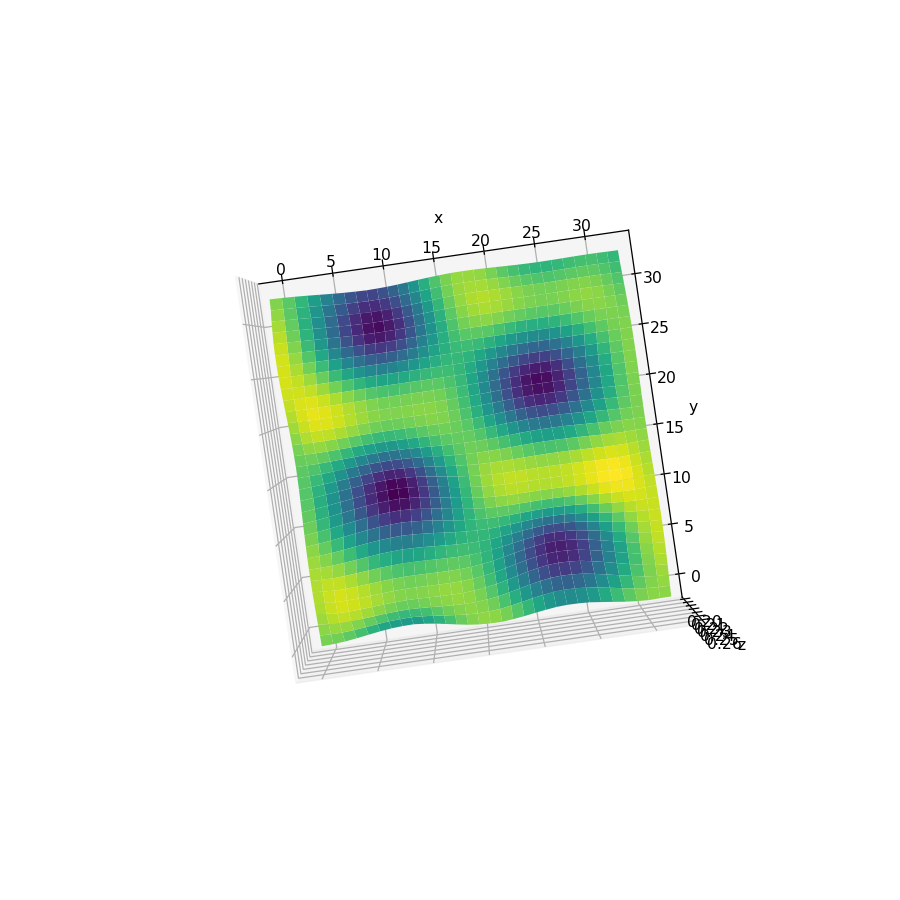

In [122]:
def plot_3d(arr):
    ny,nx = arr.shape
    x = np.linspace(0,nx,nx)
    y = np.linspace(0,ny,ny)
    xv, yv = np.meshgrid(x,y)
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111,projection='3d')
    height3d=ax.plot_surface(xv,yv,arr,linewidth=0,alpha=1,cmap='viridis')
    ax.set_zlabel('z')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

%matplotlib notebook
plot_3d(stm_slice[5,6])
#plot_3d(stm_slice_back[5,6])

#plot_3d(stm)
#plot_3d(stm_back)

-1.6666666666666667 1.3333333333333333
[5.00657552 9.32795938 7.38664131 6.47752398 3.27807809 3.27784239
 2.1174361  8.45657789 6.49363877 7.21645704]
[0.02451146 0.01315598 0.01661357 0.01894527 0.0374361  0.03743879
 0.05795616 0.0145116  0.01889826 0.01700536]


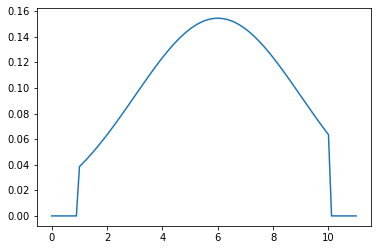

In [6]:
#Plots distributions
my_a,my_b=1,10
mean=6
std=3
a=(my_a-mean)/std
b=(my_b-mean)/std
print(a,b)
x = np.linspace(0,11,100)
%matplotlib inline
plt.plot(x,truncnorm.pdf(x,a=a,b=b,loc=mean,scale=std))
#plt.plot(x,norm.pdf(x,loc=mean,scale=std))
#plt.plot(x,randint.pmf(x,0,64))

#print(randint.rvs(0,64,size=6))
#print(norm.rvs(loc=mean,scale=std,random_state=42,size=5))

f_values=truncnorm.rvs(a=(1-6)/3,b=(10-6)/3,loc=6,scale=3,random_state=42,size=10)
print(f_values)
f_values=2*math.pi/(51.2*f_values)
print(f_values)

In [ ]:
#Creates training set and DataFrame with labels
train_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_18'

im_names=[]
central_atom_x_labels=[]
central_atom_y_labels=[]
neighbor_vect_1_x_labels=[]
neighbor_vect_1_y_labels=[]
neighbor_vect_2_x_labels=[]
neighbor_vect_2_y_labels=[]
neighbor_vect_3_x_labels=[]
neighbor_vect_3_y_labels=[]
for bl in tqdm_notebook(np.linspace(7,9,num=4),desc='bl'):
    for offx in tqdm_notebook(np.linspace(-5,5,num=5),desc='offx'):
        for offy in tqdm_notebook(np.linspace(-5,5,num=5),desc='offy'):
            for atom_size in np.linspace(2,3.5,num=3):
                for q in np.linspace(0,.1,num=5):
                    for r in np.linspace(0,.1,num=5):
                        for b in np.linspace(0,.1,num=5):
                            for angle in np.linspace(-30,30,num=8):
                                im=Training_im([bl,bl],[offx,offy],atom_size,[q,r,b],angle)
                                im_names.append(f"bl{str(bl).replace('.','').replace('-','neg')}_offx{str(offx).replace('.','').replace('-','neg')}_offy{str(offy).replace('.','').replace('-','neg')}_as{str(atom_size).replace('.','')}_strain{str(q).replace('.','')}{str(r).replace('.','')}{str(b).replace('.','')}_angle{str(angle).replace('.','').replace('-','neg')}.png")
                                central_atom_x_labels.append(im.central_atom[0])
                                central_atom_y_labels.append(im.central_atom[1])
                                neighbor_vect_1_x_labels.append(im.neighbor_vects[0][0])
                                neighbor_vect_1_y_labels.append(im.neighbor_vects[0][1])
                                neighbor_vect_2_x_labels.append(im.neighbor_vects[1][0])
                                neighbor_vect_2_y_labels.append(im.neighbor_vects[1][1])
                                neighbor_vect_3_x_labels.append(im.neighbor_vects[2][0])
                                neighbor_vect_3_y_labels.append(im.neighbor_vects[2][1])
                                im.im_fin.save(os.path.join(train_dataset_dir,f"bl{str(bl).replace('.','').replace('-','neg')}_offx{str(offx).replace('.','').replace('-','neg')}_offy{str(offy).replace('.','').replace('-','neg')}_as{str(atom_size).replace('.','')}_strain{str(q).replace('.','')}{str(r).replace('.','')}{str(b).replace('.','')}_angle{str(angle).replace('.','').replace('-','neg')}.png"))

data={
    'filename':im_names,'x_coord':central_atom_x_labels,'y_coord':central_atom_y_labels, 
    'neighbor1x':neighbor_vect_1_x_labels, 'neighbor1y':neighbor_vect_1_y_labels,
    'neighbor2x':neighbor_vect_2_x_labels, 'neighbor2y':neighbor_vect_2_y_labels,
    'neighbor3x':neighbor_vect_3_x_labels, 'neighbor3y':neighbor_vect_3_y_labels,
    }
df=pd.DataFrame(data)
df.to_csv(os.path.join(train_dataset_dir,"training_dataframe.csv"),index=False)

In [ ]:
#Creates training set and DataFrame with labels through choosing random parameter values
train_dataset_dir ='Training_set_7_15'
os.makedirs(train_dataset_dir)

DATASET_SIZE=300000
im_names=[]
central_atom_x_labels=[]
central_atom_y_labels=[]
neighbor_vect_1_x_labels=[]
neighbor_vect_1_y_labels=[]
neighbor_vect_2_x_labels=[]
neighbor_vect_2_y_labels=[]
neighbor_vect_3_x_labels=[]
neighbor_vect_3_y_labels=[]

#Sets the distributions for each parameter used during the for loop 
SEED=42
bl_values=truncnorm.rvs(a=(6.5-8)/1,b=(10-8)/1,loc=8,scale=1,random_state=SEED,size=DATASET_SIZE)
atom_size_values=truncnorm.rvs(a=(2.5-3.5)/1.5,b=(5.5-3.5)/1.5,loc=3.5,scale=1,random_state=SEED,size=DATASET_SIZE)
offx_values=uniform.rvs(loc=-5,scale=10,random_state=SEED,size=DATASET_SIZE)
offy_values=uniform.rvs(loc=-5,scale=10,random_state=SEED,size=DATASET_SIZE)
q_values=norm.rvs(scale=0.05,random_state=SEED,size=DATASET_SIZE)
r_values=norm.rvs(scale=0.05,random_state=SEED,size=DATASET_SIZE)
b_values=norm.rvs(scale=0.05,random_state=SEED,size=DATASET_SIZE)
angle_values=uniform.rvs(loc=-60,scale=120,random_state=SEED,size=DATASET_SIZE)
corr_values=truncnorm.rvs(a=(0-0.15)/0.05,b=(0.4-0.15)/0.05,loc=0.15,scale=0.05,random_state=SEED,size=DATASET_SIZE)
smear_theta_values=uniform.rvs(loc=-np.pi/2,scale=np.pi,random_state=SEED,size=DATASET_SIZE)
# lines_arr=[]
# for i in range(10):
#     lines=fBm(512,1,42+i)
#     lines_arr.append(lines)

for i in notebook.tqdm(range(DATASET_SIZE),desc='Number of Images'):
    bl=bl_values[i]
    offx=offx_values[i]
    offy=offy_values[i]
    atom_size=atom_size_values[i]
    q=q_values[i]
    r=r_values[i]
    b=b_values[i]
    angle=angle_values[i]
    corr=corr_values[i]
    smear_theta=smear_theta_values[i]
    #LINES=lines_arr[random.randint(0,9)]
    im=Training_im([bl,bl],[offx,offy],atom_size,[q,r,b],angle,corr,smear_theta)
    im_names.append(f"lattice_{i}.npy")
    central_atom_x_labels.append(im.central_atom[0])
    central_atom_y_labels.append(im.central_atom[1])
    neighbor_vect_1_x_labels.append(im.central_atom[0]+im.neighbor_vects[0][0])
    neighbor_vect_1_y_labels.append(im.central_atom[1]+im.neighbor_vects[0][1])
    neighbor_vect_2_x_labels.append(im.central_atom[0]+im.neighbor_vects[1][0])
    neighbor_vect_2_y_labels.append(im.central_atom[1]+im.neighbor_vects[1][1])
    neighbor_vect_3_x_labels.append(im.central_atom[0]+im.neighbor_vects[2][0])
    neighbor_vect_3_y_labels.append(im.central_atom[1]+im.neighbor_vects[2][1])
    np.save(os.path.join(train_dataset_dir,f"lattice_{i}.npy"),im.blob_values_array)

    if i%50000==0 and i>0:
        data={
            'filename':im_names,'x_coord':central_atom_x_labels,'y_coord':central_atom_y_labels, 
            'neighbor1x':neighbor_vect_1_x_labels, 'neighbor1y':neighbor_vect_1_y_labels,
            'neighbor2x':neighbor_vect_2_x_labels, 'neighbor2y':neighbor_vect_2_y_labels,
            'neighbor3x':neighbor_vect_3_x_labels, 'neighbor3y':neighbor_vect_3_y_labels,
            'bl':bl_values[:i+1],'offx':offx_values[:i+1],'offy':offy_values[:i+1],
            'atom_size':atom_size_values[:i+1],'q':q_values[:i+1],'r':r_values[:i+1],
            'b':b_values[:i+1],'angle':angle_values[:i+1],'corr':corr_values[:i+1],'smear_theta':smear_theta_values[:i+1]
            }
        df=pd.DataFrame(data)
        df.to_csv(os.path.join(train_dataset_dir,"training_dataframe.csv"),index=False)

#Saves the filenames and labels to a Pandas dataframe
data={
    'filename':im_names,'x_coord':central_atom_x_labels,'y_coord':central_atom_y_labels, 
    'neighbor1x':neighbor_vect_1_x_labels, 'neighbor1y':neighbor_vect_1_y_labels,
    'neighbor2x':neighbor_vect_2_x_labels, 'neighbor2y':neighbor_vect_2_y_labels,
    'neighbor3x':neighbor_vect_3_x_labels, 'neighbor3y':neighbor_vect_3_y_labels,
    'bl':bl_values,'offx':offx_values,'offy':offy_values,
    'atom_size':atom_size_values,'q':q_values,'r':r_values,
    'b':b_values,'angle':angle_values,'corr':corr_values,'smear_theta':smear_theta_values
    }
df=pd.DataFrame(data)
df.to_csv(os.path.join(train_dataset_dir,"training_dataframe.csv"),index=False)

In [82]:
#Creates testing set and DataFrame with labels through choosing random parameter values
train_dataset_dir ='Testing_set_7_13'
os.makedirs(train_dataset_dir)

DATASET_SIZE=50000
im_names=[]
central_atom_x_labels=[]
central_atom_y_labels=[]
neighbor_vect_1_x_labels=[]
neighbor_vect_1_y_labels=[]
neighbor_vect_2_x_labels=[]
neighbor_vect_2_y_labels=[]
neighbor_vect_3_x_labels=[]
neighbor_vect_3_y_labels=[]

#Sets the distributions for each parameter used during the for loop 
SEED=43
bl_values=truncnorm.rvs(a=(1-9)/1,b=(15-9)/1,loc=9,scale=1,random_state=SEED,size=DATASET_SIZE)
atom_size_values=truncnorm.rvs(a=(1.5-2.75)/1.5,b=(4-2.75)/1.5,loc=2.75,scale=1.5,random_state=SEED,size=DATASET_SIZE)
offx_values=uniform.rvs(loc=-5,scale=10,random_state=SEED,size=DATASET_SIZE)
offy_values=uniform.rvs(loc=-5,scale=10,random_state=SEED,size=DATASET_SIZE)
q_values=norm.rvs(scale=0.05,random_state=SEED,size=DATASET_SIZE)
r_values=norm.rvs(scale=0.05,random_state=SEED,size=DATASET_SIZE)
b_values=norm.rvs(scale=0.05,random_state=SEED,size=DATASET_SIZE)
angle_values=uniform.rvs(loc=-30,scale=60,random_state=SEED,size=DATASET_SIZE)
corr_values=truncnorm.rvs(a=(0-0.15)/0.05,b=(0.4-0.15)/0.05,loc=0.15,scale=0.05,random_state=SEED,size=DATASET_SIZE)
lines_arr=[]
for i in range(10):
    lines=fBm(512,1,52+i)
    lines_arr.append(lines)

for i in notebook.tqdm(range(DATASET_SIZE),desc='num_images'):
    bl=bl_values[i]
    offx=offx_values[i]
    offy=offy_values[i]
    atom_size=atom_size_values[i]
    q=q_values[i]
    r=r_values[i]
    b=b_values[i]
    angle=angle_values[i]
    corr=corr_values[i]
    LINES=lines_arr[random.randint(0,9)]
    im=Training_im([bl,bl],[offx,offy],atom_size,[q,r,b],angle,corr)
    im_names.append(f"lattice_{i}.npy")
    central_atom_x_labels.append(im.central_atom[0])
    central_atom_y_labels.append(im.central_atom[1])
    neighbor_vect_1_x_labels.append(im.neighbor_vects[0][0])
    neighbor_vect_1_y_labels.append(im.neighbor_vects[0][1])
    neighbor_vect_2_x_labels.append(im.neighbor_vects[1][0])
    neighbor_vect_2_y_labels.append(im.neighbor_vects[1][1])
    neighbor_vect_3_x_labels.append(im.neighbor_vects[2][0])
    neighbor_vect_3_y_labels.append(im.neighbor_vects[2][1])
    np.save(os.path.join(train_dataset_dir,f"lattice_{i}.npy"),im.blob_values_array)


#Saves the filenames and labels to a Pandas dataframe
data={
    'filename':im_names,'x_coord':central_atom_x_labels,'y_coord':central_atom_y_labels, 
    'neighbor1x':neighbor_vect_1_x_labels, 'neighbor1y':neighbor_vect_1_y_labels,
    'neighbor2x':neighbor_vect_2_x_labels, 'neighbor2y':neighbor_vect_2_y_labels,
    'neighbor3x':neighbor_vect_3_x_labels, 'neighbor3y':neighbor_vect_3_y_labels,
    'bl':bl_values,'offx':offx_values,'offy':offy_values,
    'atom_size':atom_size_values,'q':q_values,'r':r_values,
    'b':b_values,'angle':angle_values,'corr':corr_values
    }
df=pd.DataFrame(data)
df.to_csv(os.path.join(train_dataset_dir,"training_dataframe.csv"),index=False)

In [ ]:
#Creates testing set and DataFrame with labels
train_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Testing_set_6_18' 

im_names=[]
central_atom_x_labels=[]
central_atom_y_labels=[]
neighbor_vect_1_x_labels=[]
neighbor_vect_1_y_labels=[]
neighbor_vect_2_x_labels=[]
neighbor_vect_2_y_labels=[]
neighbor_vect_3_x_labels=[]
neighbor_vect_3_y_labels=[]
for bl in tqdm_notebook(np.linspace(7.3,9,num=3,endpoint=False),desc='bl'):
    for offx in tqdm_notebook(np.linspace(-5.4,5,num=3,endpoint=False),desc='offx'):
        for offy in tqdm_notebook(np.linspace(-5.6,5,num=3,endpoint=False),desc='offy'):
            for atom_size in np.linspace(2.1,3.2,num=3,endpoint=False):
                for q in np.linspace(0.003,.1,num=3,endpoint=False):
                    for r in np.linspace(0.004,.1,num=3,endpoint=False):
                        for b in np.linspace(0.002,.1,num=3,endpoint=False):
                            for angle in np.linspace(-30.3,30,num=5,endpoint=False):
                                im=Training_im([bl,bl],[offx,offy],atom_size,[q,r,b],angle)
                                im_names.append(f"bl{str(bl).replace('.','').replace('-','neg')}_offx{str(offx).replace('.','').replace('-','neg')}_offy{str(offy).replace('.','').replace('-','neg')}_as{str(atom_size).replace('.','')}_strain{str(q).replace('.','')}{str(r).replace('.','')}{str(b).replace('.','')}_angle{str(angle).replace('.','').replace('-','neg')}.png")
                                central_atom_x_labels.append(im.central_atom[0])
                                central_atom_y_labels.append(im.central_atom[1])
                                neighbor_vect_1_x_labels.append(im.neighbor_vects[0][0])
                                neighbor_vect_1_y_labels.append(im.neighbor_vects[0][1])
                                neighbor_vect_2_x_labels.append(im.neighbor_vects[1][0])
                                neighbor_vect_2_y_labels.append(im.neighbor_vects[1][1])
                                neighbor_vect_3_x_labels.append(im.neighbor_vects[2][0])
                                neighbor_vect_3_y_labels.append(im.neighbor_vects[2][1])
                                im.im_fin.save(os.path.join(train_dataset_dir,f"bl{str(bl).replace('.','').replace('-','neg')}_offx{str(offx).replace('.','').replace('-','neg')}_offy{str(offy).replace('.','').replace('-','neg')}_as{str(atom_size).replace('.','')}_strain{str(q).replace('.','')}{str(r).replace('.','')}{str(b).replace('.','')}_angle{str(angle).replace('.','').replace('-','neg')}.png"))

data={
    'filename':im_names,'x_coord':central_atom_x_labels,'y_coord':central_atom_y_labels, 
    'neighbor1x':neighbor_vect_1_x_labels, 'neighbor1y':neighbor_vect_1_y_labels,
    'neighbor2x':neighbor_vect_2_x_labels, 'neighbor2y':neighbor_vect_2_y_labels,
    'neighbor3x':neighbor_vect_3_x_labels, 'neighbor3y':neighbor_vect_3_y_labels,
    }
df=pd.DataFrame(data)
df.to_csv(os.path.join(train_dataset_dir,"training_dataframe.csv"),index=False)